In [44]:
# Import relevant packages
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
# read in data
traffic_data = pd.read_csv("data/master.csv")

# Measuring Automation

In this notebook we will be measuring how automated vehicles impact the flow rate of traffic. We will focus on rush hour traffic in the Puget Sound area.

## Rush Hour Traffic

First we find the rush hour rate for each section of highway. From the problem, we know that rush hour traffic accounts for 8% of the total traffic.

In [46]:
# rush hour rate: 8 percent of the daily traffic
traffic_data['rush_hour_rate'] = traffic_data['Average daily traffic counts Year_2015'] * 0.08

We can see below we are dealing with traffic for 4 different highways.

Text(0.5, 1.0, 'Route ID Frequencies')

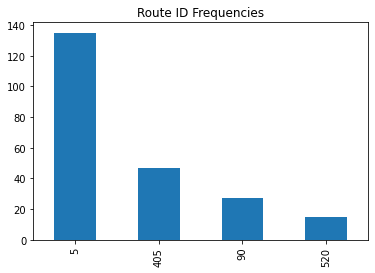

In [47]:
traffic_data.dtypes

# Convert Route_ID to categorical and plot histogram
traffic_data['Route_ID'] = traffic_data['Route_ID'].astype('category')


traffic_data['Route_ID'].value_counts().plot(kind='bar')
plt.title("Route ID Frequencies")

It might be helpful to have next and prev section of highway information for future calculations.

In [48]:
# Will find the previous section of highway based on mileposts and route id
def find_prev_section(traffic_data, index):
    former_sect = -1
    for i in range(len(traffic_data)):
        # starts search from index and decreases
        step = (index - i) % len(traffic_data)
        if traffic_data.loc[index, 'Route_ID'] == traffic_data.loc[step, 'Route_ID']:
            if traffic_data.loc[index, 'startMilepost'] == traffic_data.loc[step, 'endMilepost']:
                former_sect = step
                break
    return former_sect

# Will find the next section of highway based on mileposts and route id
def find_next_section(traffic_data, index):
    next_sect = -1
    for i in range(len(traffic_data)):
        # starts search from index and increases
        step = (index + i) % len(traffic_data)
        if traffic_data.loc[index, 'Route_ID'] == traffic_data.loc[step, 'Route_ID']:
            if traffic_data.loc[index, 'endMilepost'] == traffic_data.loc[step, 'startMilepost']:
                next_sect = step
                break
    return next_sect

In [49]:
# Find previous and next section for each section of highway
for index in range(len(traffic_data)):
    traffic_data.loc[index, 'prev_sect_id'] = find_prev_section(traffic_data, index)
    traffic_data.loc[index, 'next_sect_id'] = find_next_section(traffic_data, index)
    

# Previous and next section of hw id's should be integers, not floats.
traffic_data['prev_sect_id'] = traffic_data['prev_sect_id'].astype('int64')
traffic_data['next_sect_id'] = traffic_data['next_sect_id'].astype('int64')

# Will fix rush hour rate here as well.
traffic_data['rush_hour_rate'] = traffic_data['rush_hour_rate'].astype('int64')

traffic_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Route_ID,startMilepost,endMilepost,Average daily traffic counts Year_2015,"RteType (IS= Interstate, SR= State Route)",Number of Lanes DECR MP direction,Number of Lanes INCR MP direction,...,flow_decr_lane_0,flow_incr_lane_0,flow_decr_lane_1,flow_incr_lane_1,flow_decr_lane_2,flow_incr_lane_2,flow_decr_lane_3,flow_incr_lane_3,flow_decr_lane_4,flow_incr_lane_4
0,0,0,0,5,100.93,101.87,65000,IS,3,3,...,4800.0,4800.0,5180.884641,5180.884641,5561.769282,5561.769282,5942.653923,5942.653923,5942.653923,5942.653923
1,1,1,1,5,101.87,103.17,85000,IS,3,3,...,4800.0,4800.0,5180.884641,5180.884641,5561.769282,5561.769282,5942.653923,5942.653923,5942.653923,5942.653923
2,2,2,2,5,103.17,103.42,108000,IS,3,3,...,4800.0,4800.0,5180.884641,5180.884641,5561.769282,5561.769282,5942.653923,5942.653923,5942.653923,5942.653923
3,3,3,3,5,103.42,104.81,101000,IS,3,3,...,4800.0,4800.0,5180.884641,5180.884641,5561.769282,5561.769282,5942.653923,5942.653923,5942.653923,5942.653923
4,4,4,4,5,104.81,105.63,144000,IS,3,4,...,4800.0,6400.0,5180.884641,6780.884641,5561.769282,7161.769282,5942.653923,7542.653923,5942.653923,7923.538564


## Accounting for the Direction of Traffic

Each section of highway has an increasing and a decreasing section. With each of these being a part of a different flow of traffic, we will divide the rush hour traffic between these two directions. We will do so proportionally to the number of lanes on either side of the highway, so each lane has an equal number of cars.

In [50]:
# making rush hour in incr and decr directions
# NOTE: proportional to the number of lanes on each side
traffic_data.rename(columns={'Number of Lanes DECR MP direction ':'Number of Lanes DECR MP direction'}, inplace=True)

traffic_data['rush_hour_decr_mp'] = traffic_data['rush_hour_rate'] * traffic_data['Number of Lanes DECR MP direction'] / (traffic_data['Number of Lanes DECR MP direction'] + traffic_data['Number of Lanes INCR MP direction'])
traffic_data['rush_hour_incr_mp'] = traffic_data['rush_hour_rate'] * traffic_data['Number of Lanes INCR MP direction'] / (traffic_data['Number of Lanes DECR MP direction'] + traffic_data['Number of Lanes INCR MP direction'])

traffic_data['rush_hour_decr_mp'] = traffic_data['rush_hour_decr_mp'].astype('int64')
traffic_data['rush_hour_incr_mp'] = traffic_data['rush_hour_incr_mp'].astype('int64')

traffic_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Route_ID,startMilepost,endMilepost,Average daily traffic counts Year_2015,"RteType (IS= Interstate, SR= State Route)",Number of Lanes DECR MP direction,Number of Lanes INCR MP direction,...,flow_decr_lane_0,flow_incr_lane_0,flow_decr_lane_1,flow_incr_lane_1,flow_decr_lane_2,flow_incr_lane_2,flow_decr_lane_3,flow_incr_lane_3,flow_decr_lane_4,flow_incr_lane_4
0,0,0,0,5,100.93,101.87,65000,IS,3,3,...,4800.0,4800.0,5180.884641,5180.884641,5561.769282,5561.769282,5942.653923,5942.653923,5942.653923,5942.653923
1,1,1,1,5,101.87,103.17,85000,IS,3,3,...,4800.0,4800.0,5180.884641,5180.884641,5561.769282,5561.769282,5942.653923,5942.653923,5942.653923,5942.653923
2,2,2,2,5,103.17,103.42,108000,IS,3,3,...,4800.0,4800.0,5180.884641,5180.884641,5561.769282,5561.769282,5942.653923,5942.653923,5942.653923,5942.653923
3,3,3,3,5,103.42,104.81,101000,IS,3,3,...,4800.0,4800.0,5180.884641,5180.884641,5561.769282,5561.769282,5942.653923,5942.653923,5942.653923,5942.653923
4,4,4,4,5,104.81,105.63,144000,IS,3,4,...,4800.0,6400.0,5180.884641,6780.884641,5561.769282,7161.769282,5942.653923,7542.653923,5942.653923,7923.538564


## Changes in Traffic by Section of Highway

Using the previous and next sections of highway data created earlier, we can find the change in traffic for each section. This measure is the difference between the number of people getting on and off of the highway 

In [51]:
for i in range(len(traffic_data)):
    next_section = traffic_data.loc[i, 'next_sect_id']
    prev_section = traffic_data.loc[i, 'prev_sect_id']
    if prev_section == -1:
        traffic_data.loc[i, 'delta_incr'] = traffic_data.loc[i, 'rush_hour_incr_mp']
    else:
        traffic_data.loc[i, 'delta_incr'] = traffic_data.loc[i, 'rush_hour_incr_mp'] - traffic_data.loc[prev_section, 'rush_hour_incr_mp']
    if next_section == -1:
        traffic_data.loc[i, 'delta_decr'] = traffic_data.loc[i, 'rush_hour_decr_mp']
    else:
        traffic_data.loc[i, 'delta_decr'] = traffic_data.loc[i, 'rush_hour_decr_mp'] - traffic_data.loc[next_section, 'rush_hour_decr_mp']
        
traffic_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Route_ID,startMilepost,endMilepost,Average daily traffic counts Year_2015,"RteType (IS= Interstate, SR= State Route)",Number of Lanes DECR MP direction,Number of Lanes INCR MP direction,...,flow_decr_lane_0,flow_incr_lane_0,flow_decr_lane_1,flow_incr_lane_1,flow_decr_lane_2,flow_incr_lane_2,flow_decr_lane_3,flow_incr_lane_3,flow_decr_lane_4,flow_incr_lane_4
0,0,0,0,5,100.93,101.87,65000,IS,3,3,...,4800.0,4800.0,5180.884641,5180.884641,5561.769282,5561.769282,5942.653923,5942.653923,5942.653923,5942.653923
1,1,1,1,5,101.87,103.17,85000,IS,3,3,...,4800.0,4800.0,5180.884641,5180.884641,5561.769282,5561.769282,5942.653923,5942.653923,5942.653923,5942.653923
2,2,2,2,5,103.17,103.42,108000,IS,3,3,...,4800.0,4800.0,5180.884641,5180.884641,5561.769282,5561.769282,5942.653923,5942.653923,5942.653923,5942.653923
3,3,3,3,5,103.42,104.81,101000,IS,3,3,...,4800.0,4800.0,5180.884641,5180.884641,5561.769282,5561.769282,5942.653923,5942.653923,5942.653923,5942.653923
4,4,4,4,5,104.81,105.63,144000,IS,3,4,...,4800.0,6400.0,5180.884641,6780.884641,5561.769282,7161.769282,5942.653923,7542.653923,5942.653923,7923.538564


## Free Flow Rate of Traffic

**Free Flow** occcurs when vehicles travel unaffected by other traffic. The Free Flow Rate represents the optimal capacity of the system. Traffic slows when it gets above this rate.  

The *Traffic Data Computation Method Pocket Guide* by the US Department of Transportation provides the following table on flow rates versus free flow speed.

| Free Flow Speed (mph) | Flow Rate (pc/h/ln) |
|:--------------------- |:------------------- |
| 75                    | 1,150               |
| 70                    | 1,300               |
| 65                    | 1,450               |
| 60                    | 1,600               |
| 55                    | 1,750               |

In [52]:
'''
Since our speed limits are at 60 mph for all the roads, free flow capacity will be found multiplying
1600 by the number of lanes in each direction.
'''

traffic_data['free_flow_decr'] = 1600 * traffic_data['Number of Lanes DECR MP direction']
traffic_data['free_flow_incr'] = 1600 * traffic_data['Number of Lanes INCR MP direction']
traffic_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Route_ID,startMilepost,endMilepost,Average daily traffic counts Year_2015,"RteType (IS= Interstate, SR= State Route)",Number of Lanes DECR MP direction,Number of Lanes INCR MP direction,...,flow_decr_lane_0,flow_incr_lane_0,flow_decr_lane_1,flow_incr_lane_1,flow_decr_lane_2,flow_incr_lane_2,flow_decr_lane_3,flow_incr_lane_3,flow_decr_lane_4,flow_incr_lane_4
0,0,0,0,5,100.93,101.87,65000,IS,3,3,...,4800.0,4800.0,5180.884641,5180.884641,5561.769282,5561.769282,5942.653923,5942.653923,5942.653923,5942.653923
1,1,1,1,5,101.87,103.17,85000,IS,3,3,...,4800.0,4800.0,5180.884641,5180.884641,5561.769282,5561.769282,5942.653923,5942.653923,5942.653923,5942.653923
2,2,2,2,5,103.17,103.42,108000,IS,3,3,...,4800.0,4800.0,5180.884641,5180.884641,5561.769282,5561.769282,5942.653923,5942.653923,5942.653923,5942.653923
3,3,3,3,5,103.42,104.81,101000,IS,3,3,...,4800.0,4800.0,5180.884641,5180.884641,5561.769282,5561.769282,5942.653923,5942.653923,5942.653923,5942.653923
4,4,4,4,5,104.81,105.63,144000,IS,3,4,...,4800.0,6400.0,5180.884641,6780.884641,5561.769282,7161.769282,5942.653923,7542.653923,5942.653923,7923.538564


Text(0.5, 1.0, 'Rush Hour Rate versus Free Flow Traffic')

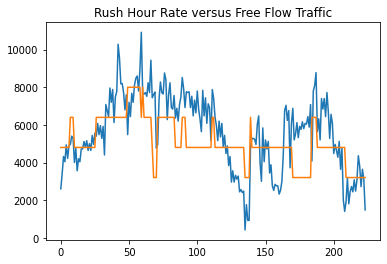

In [53]:
# Here we can see the free flow capacity versus the rush hour traffic.

plt.plot(traffic_data['Unnamed: 0'], traffic_data['rush_hour_decr_mp'])
plt.plot(traffic_data['Unnamed: 0'], traffic_data['free_flow_decr'])
plt.title("Rush Hour Rate versus Free Flow Traffic")

In many places the rush hour traffic exceeds the free flow rate. This indicates congestion on the highways.

## Measuring Traffic Congestion

We need a way to measure how this traffic congestion is impacted by autonomous vehicles. For lack of a better measure, we will use **overflow percentage** here. This is the percentage of highway sections that are over the free flow threshold.

In [54]:
# Compute the overflow rate for decreasing sections of highway
count = 0
for i in range(len(traffic_data)):
    if traffic_data.loc[i, 'rush_hour_decr_mp'] > traffic_data.loc[i, 'free_flow_decr']:
            count = count + 1

        
count/len(traffic_data)    

0.6026785714285714

As a baseline, about **60.26%** of the highway sections in the decreasing direction are above the desired free-flow capacity.

## Measuring AV Impact

For our research, we did not create our own traffic models. Lu et al. measured the impact of autonomous vehicles using a microscopic traffic simulation. We will use their results here.

In [55]:

# Taken from Lu et al.
BASE_FLOW = 13497

# The results from Lu et al. model
av_penetration = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
max_flow_lu_test = [13497, 13765, 14040, 14324, 14616, 14919, 15234, 15563, 15910, 16283, 16710]

# The flow increase ratio will allow us to apply the lu et al. results to our data 
flow_increase_ratio = map(lambda x: x/13497, max_flow_lu_test)

# Making the data into a pandas df
d = {'av_penetration':av_penetration, 'maximum_flow':max_flow_lu_test, 'flow_increase_ratio':flow_increase_ratio}
auto_cars = pd.DataFrame(data=d)
auto_cars['flow_increase_ratio']

0     1.000000
1     1.019856
2     1.040231
3     1.061273
4     1.082907
5     1.105357
6     1.128695
7     1.153071
8     1.178780
9     1.206416
10    1.238053
Name: flow_increase_ratio, dtype: float64

In [11]:
# Now we will apply these same ratios to the predicted maximum flow for our highways

for i in range(len(traffic_data)):
        for j in range(len(auto_cars)):
            av_pen = auto_cars.loc[j, 'av_penetration']
            col1 = f'flow_decr_ap_{av_pen}'
            col2 = f'flow_incr_ap_{av_pen}'  
            traffic_data.loc[i, col1] = traffic_data.loc[i, 'free_flow_decr'] * auto_cars.loc[j, 'flow_increase_ratio']
            traffic_data.loc[i, col2] = traffic_data.loc[i, 'free_flow_incr'] * auto_cars.loc[j, 'flow_increase_ratio']

traffic_data[col1] = traffic_data[col1].astype('int64')
traffic_data[col2] = traffic_data[col2].astype('int64')
            
traffic_data

,Unnamed: 0,Route_ID,startMilepost,endMilepost,Average daily traffic counts Year_2015,"RteType (IS= Interstate, SR= State Route)",Number of Lanes DECR MP direction,Number of Lanes INCR MP direction,Unnamed: 7,Comments,...,flow_decr_ap_0.6,flow_incr_ap_0.6,flow_decr_ap_0.7,flow_incr_ap_0.7,flow_decr_ap_0.8,flow_incr_ap_0.8,flow_decr_ap_0.9,flow_incr_ap_0.9,flow_decr_ap_1.0,flow_incr_ap_1.0
0,0,5,100.93,101.87,65000,IS,3,3,NaN,Olympia,...,5417.737275,5417.737275,5534.741054,5534.741054,5658.146255,5658.146255,5790.797955,5790.797955,5942,5942
1,1,5,101.87,103.17,85000,IS,3,3,NaN,NaN,...,5417.737275,5417.737275,5534.741054,5534.741054,5658.146255,5658.146255,5790.797955,5790.797955,5942,5942
2,2,5,103.17,103.42,108000,IS,3,3,NaN,NaN,...,5417.737275,5417.737275,5534.741054,5534.741054,5658.146255,5658.146255,5790.797955,5790.797955,5942,5942
3,3,5,103.42,104.81,101000,IS,3,3,NaN,NaN,...,5417.737275,5417.737275,5534.741054,5534.741054,5658.146255,5658.146255,5790.797955,5790.797955,5942,5942
4,4,5,104.81,105.63,144000,IS,3,4,NaN,Rte 101 intersection,...,5417.737275,7223.649700,5534.741054,7379.654738,5658.146255,7544.195006,5790.797955,7721.063940,5942,7923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,520,9.60,9.72,95000,SR,2,2,NaN,NaN,...,3611.824850,3611.824850,3689.827369,3689.827369,3772.097503,3772.097503,3860.531970,3860.531970,3961,3961
220,220,520,9.72,11.35,68000,SR,2,2,NaN,NaN,...,3611.824850,3611.824850,3689.827369,3689.827369,3772.097503,3772.097503,3860.531970,3860.531970,3961,3961
221,221,520,11.35,12.05,91000,SR,2,2,NaN,NaN,...,3611.824850,3611.824850,3689.827369,3689.827369,3772.097503,3772.097503,3860.531970,3860.531970,3961,3961
222,222,520,12.05,12.38,78000,SR,2,2,NaN,NaN,...,3611.824850,3611.824850,3689.827369,3689.827369,3772.097503,3772.097503,3860.531970,3860.531970,3961,3961


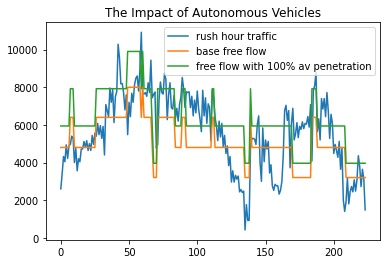

In [60]:
# Now plotting the same curves versus the ap_pen free flow estimates

plt.plot(traffic_data['Unnamed: 0'], traffic_data['rush_hour_decr_mp'])
plt.plot(traffic_data['Unnamed: 0'], traffic_data['free_flow_decr'])
plt.plot(traffic_data['Unnamed: 0'], traffic_data['flow_decr_ap_1.0'])
plt.title("The Impact of Autonomous Vehicles")
plt.legend(('rush hour traffic', 'base free flow', 'free flow with 100% av penetration'))

In [61]:
# A function to compute the overflow percentage of traffic compared to a free flow threshold
def compute_overflow_percentage(t_data, flow_rate_col, free_flow_col):
    count = 0
    for i in range(len(t_data)):
        if t_data.loc[i, flow_rate_col] > t_data.loc[i, free_flow_col]:
                count = count + 1

    return count/len(t_data)  
    

compute_overflow_percentage(traffic_data, 'rush_hour_decr_mp', 'flow_decr_ap_1.0')

0.3392857142857143

From here we can compute the overflow percentages for increasing and decreasing highways based on autonomous vehicle penetration

In [62]:
av_penetration
overflow_perc_decr = []
overflow_perc_incr = []
for i in range(len(av_penetration)):
    if i == 0:
        colname1 = 'free_flow_decr'
        colname2 = 'free_flow_incr'
    else:
        colname1 = f'flow_decr_ap_{av_penetration[i]}'
        colname2 = f'flow_incr_ap_{av_penetration[i]}'
    
    overflow_perc_decr.append(compute_overflow_percentage(traffic_data, 'rush_hour_decr_mp', colname1))
    overflow_perc_incr.append(compute_overflow_percentage(traffic_data, 'rush_hour_incr_mp', colname2))
    

d = {'av_penetration':av_penetration, 'overflow_perc_decr':overflow_perc_decr, 'overflow_perc_incr':overflow_perc_incr}
overflow_rates = pd.DataFrame(data=d)
overflow_rates

,av_penetration,overflow_perc_decr,overflow_perc_incr
0,0.0,0.602679,0.602679
1,0.1,0.584821,0.584821
2,0.2,0.562500,0.562500
3,0.3,0.549107,0.549107
4,0.4,0.500000,0.500000
5,0.5,0.473214,0.473214
6,0.6,0.455357,0.455357
7,0.7,0.437500,0.437500
8,0.8,0.410714,0.410714
9,0.9,0.366071,0.366071


Text(0.5, 1.0, 'Overflow Rate versus AV Penetration')

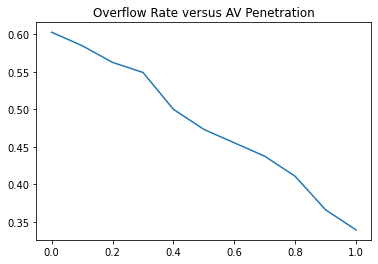

In [63]:
plt.plot(overflow_rates['av_penetration'], overflow_rates['overflow_perc_decr'])
plt.title('Overflow Rate versus AV Penetration')

## Measuring Overflow Rates by Highway

In [17]:
def compute_overflow_by_highway(highway):
    overflow_perc_decr_hw = []
    overflow_perc_incr_hw = []
    for i in range(len(av_penetration)):
        if i == 0:
            colname1 = 'free_flow_decr'
            colname2 = 'free_flow_incr'
        else:
            colname1 = f'flow_decr_ap_{av_penetration[i]}'
            colname2 = f'flow_incr_ap_{av_penetration[i]}'
        
        t_data_hw = traffic_data[traffic_data.Route_ID == highway]
        t_data_hw = t_data_hw.reset_index()
        overflow_perc_decr_hw.append(compute_overflow_percentage(t_data_hw, 'rush_hour_decr_mp', colname1))
        overflow_perc_incr_hw.append(compute_overflow_percentage(t_data_hw, 'rush_hour_incr_mp', colname2))
    
    return overflow_perc_decr_hw, overflow_perc_incr_hw


routes = [5, 405, 90, 520]
for route in routes:
    decr, incr = f'overflow_{route}_decr', f'overflow_{route}_incr'
    overflow_rates[decr], overflow_rates[incr] = compute_overflow_by_highway(route)

overflow_rates

,av_penetration,overflow_perc_decr,overflow_perc_incr,overflow_5_decr,overflow_5_incr,overflow_405_decr,overflow_405_incr,overflow_90_decr,overflow_90_incr,overflow_520_decr,overflow_520_incr
0,0.0,0.602679,0.602679,0.644444,0.644444,0.765957,0.765957,0.333333,0.333333,0.200000,0.200000
1,0.1,0.584821,0.584821,0.614815,0.614815,0.765957,0.765957,0.333333,0.333333,0.200000,0.200000
2,0.2,0.562500,0.562500,0.592593,0.592593,0.744681,0.744681,0.296296,0.296296,0.200000,0.200000
3,0.3,0.549107,0.549107,0.570370,0.570370,0.744681,0.744681,0.296296,0.296296,0.200000,0.200000
4,0.4,0.500000,0.500000,0.503704,0.503704,0.723404,0.723404,0.259259,0.259259,0.200000,0.200000
5,0.5,0.473214,0.473214,0.503704,0.503704,0.680851,0.680851,0.111111,0.111111,0.200000,0.200000
6,0.6,0.455357,0.455357,0.474074,0.474074,0.680851,0.680851,0.111111,0.111111,0.200000,0.200000
7,0.7,0.437500,0.437500,0.451852,0.451852,0.680851,0.680851,0.111111,0.111111,0.133333,0.133333
8,0.8,0.410714,0.410714,0.414815,0.414815,0.659574,0.659574,0.111111,0.111111,0.133333,0.133333
9,0.9,0.366071,0.366071,0.348148,0.348148,0.659574,0.659574,0.111111,0.111111,0.066667,0.066667


## Sum Overflow

Rather than just relying on overflow percentages, we like look at the total sum of traffic that overflows on a highway. This sum overflow measure can be viewed as a percentage of the total traffic.

In [64]:
def compute_sum_overflow(t_data, flow_rate_col, free_flow_col):
    overflow_sum = 0
    for i in range(len(t_data)):
        if t_data.loc[i, flow_rate_col] > t_data.loc[i, free_flow_col]:
                overflow_sum = overflow_sum + (t_data.loc[i, flow_rate_col] - t_data.loc[i, free_flow_col])

    return overflow_sum  

def overflow_sum_percentage(t_data, flow_rate_col, free_flow_col):
    return compute_sum_overflow(t_data, flow_rate_col, free_flow_col) / t_data[flow_rate_col].sum()



overflow_sum_decr = []
overflow_sum_incr = []
for i in range(len(av_penetration)):
    if i == 0:
        colname1 = 'free_flow_decr'
        colname2 = 'free_flow_incr'
    else:
        colname1 = f'flow_decr_ap_{av_penetration[i]}'
        colname2 = f'flow_incr_ap_{av_penetration[i]}'
    
    overflow_sum_decr.append(overflow_sum_percentage(traffic_data, 'rush_hour_decr_mp', colname1))
    overflow_sum_incr.append(overflow_sum_percentage(traffic_data, 'rush_hour_incr_mp', colname2))


overflow_rates['overflow_sum_perc_decr'] = overflow_sum_decr
overflow_rates['overflow_sum_perc_incr'] = overflow_sum_incr

Text(0.5, 1.0, 'Sum Overflow Percentage versus AV Penetration')

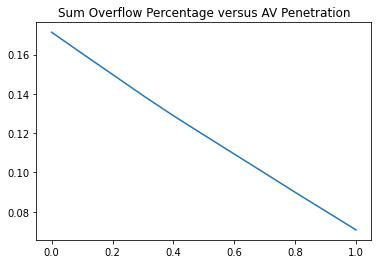

In [66]:
# plt.plot(overflow_rates['av_penetration'], overflow_rates['overflow_perc_decr'])
plt.plot(overflow_rates['av_penetration'], overflow_rates['overflow_sum_perc_decr'])
plt.title('Sum Overflow Percentage versus AV Penetration')

In [20]:
def compute_overflow_sum_by_highway(highway):
    overflow_perc_decr_hw = []
    overflow_perc_incr_hw = []
    for i in range(len(av_penetration)):
        if i == 0:
            colname1 = 'free_flow_decr'
            colname2 = 'free_flow_incr'
        else:
            colname1 = f'flow_decr_ap_{av_penetration[i]}'
            colname2 = f'flow_incr_ap_{av_penetration[i]}'
        
        t_data_hw = traffic_data[traffic_data.Route_ID == highway]
        t_data_hw = t_data_hw.reset_index()
        overflow_perc_decr_hw.append(overflow_sum_percentage(t_data_hw, 'rush_hour_decr_mp', colname1))
        overflow_perc_incr_hw.append(overflow_sum_percentage(t_data_hw, 'rush_hour_incr_mp', colname2))
    
    return overflow_perc_decr_hw, overflow_perc_incr_hw


routes = [5, 405, 90, 520]
for route in routes:
    decr, incr = f'overflow_sum_{route}_decr', f'overflow_sum_{route}_incr'
    overflow_rates[decr], overflow_rates[incr] = compute_overflow_sum_by_highway(route)

overflow_rates

,av_penetration,overflow_perc_decr,overflow_perc_incr,overflow_5_decr,overflow_5_incr,overflow_405_decr,overflow_405_incr,overflow_90_decr,overflow_90_incr,overflow_520_decr,...,overflow_sum_perc_decr,overflow_sum_perc_incr,overflow_sum_5_decr,overflow_sum_5_incr,overflow_sum_405_decr,overflow_sum_405_incr,overflow_sum_90_decr,overflow_sum_90_incr,overflow_sum_520_decr,overflow_sum_520_incr
0,0.0,0.602679,0.602679,0.644444,0.644444,0.765957,0.765957,0.333333,0.333333,0.200000,...,0.171353,0.172864,0.157043,0.159661,0.275094,0.275630,0.062490,0.062360,0.052083,0.052083
1,0.1,0.584821,0.584821,0.614815,0.614815,0.765957,0.765957,0.333333,0.333333,0.200000,...,0.160534,0.162054,0.145837,0.148444,0.263673,0.264267,0.053900,0.053788,0.047571,0.047571
2,0.2,0.562500,0.562500,0.592593,0.592593,0.744681,0.744681,0.296296,0.296296,0.200000,...,0.149858,0.151426,0.134893,0.137545,0.252076,0.252731,0.045417,0.045322,0.042940,0.042940
3,0.3,0.549107,0.549107,0.570370,0.570370,0.744681,0.744681,0.296296,0.296296,0.200000,...,0.139140,0.140774,0.123890,0.126611,0.240348,0.241070,0.037325,0.037247,0.038158,0.038158
4,0.4,0.500000,0.500000,0.503704,0.503704,0.723404,0.723404,0.259259,0.259259,0.200000,...,0.128859,0.130563,0.113493,0.116284,0.228578,0.229374,0.029786,0.029724,0.033241,0.033241
5,0.5,0.473214,0.473214,0.503704,0.503704,0.680851,0.680851,0.111111,0.111111,0.200000,...,0.119048,0.120829,0.103496,0.106361,0.216951,0.217833,0.024464,0.024413,0.028139,0.028139
6,0.6,0.455357,0.455357,0.474074,0.474074,0.680851,0.680851,0.111111,0.111111,0.200000,...,0.109325,0.111187,0.093452,0.096395,0.205188,0.206164,0.021098,0.021054,0.022834,0.022834
7,0.7,0.437500,0.437500,0.451852,0.451852,0.680851,0.680851,0.111111,0.111111,0.133333,...,0.099628,0.101576,0.083584,0.086609,0.192902,0.193977,0.017583,0.017547,0.018474,0.018474
8,0.8,0.410714,0.410714,0.414815,0.414815,0.659574,0.659574,0.111111,0.111111,0.133333,...,0.089851,0.091855,0.073790,0.076847,0.180011,0.181191,0.013876,0.013847,0.014579,0.014579
9,0.9,0.366071,0.366071,0.348148,0.348148,0.659574,0.659574,0.111111,0.111111,0.066667,...,0.080286,0.082323,0.064462,0.067509,0.166573,0.167873,0.009890,0.009870,0.011825,0.011825


## Results

We have found a linear relationship between AV Penetration and both overflow percentage and sum overflow percentage.

In [67]:
overflow_rates['flow_increase_ratio'] = auto_cars['flow_increase_ratio']
overflow_rates['flow_increase_ratio'] 

0     1.000000
1     1.019856
2     1.040231
3     1.061273
4     1.082907
5     1.105357
6     1.128695
7     1.153071
8     1.178780
9     1.206416
10    1.238053
Name: flow_increase_ratio, dtype: float64

In [68]:
overflow_rates.to_csv('data/overflow_rates.csv')
traffic_data.to_csv('data/master.csv')